In [1]:
### import pandas as pd
import seaborn as sns
import pybedtools as pbt
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

## Prepare list of genes, adding promoters
To link SNPs, peaks, and loops to genes, we first need a list of genes and their coordinates. I'll download this from GENCODE as a GTF, then extract the necessary info and convert the coordinates to BED for use in intersection with pyBedTools

In [2]:
# Change the working directory to the data dir
%cd ../data/snp_data

/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data


In [3]:
%pwd

'/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data'

In [4]:
# # Download genome annotation and extract whole-gene records
# ! mkdir -p resources
# ! curl ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_33/gencode.v33.annotation.gtf.gz | \
#     gunzip -c | awk '{OFS="\t"}{if ($3 == "gene"){print $0}}' > resources/gencode.v33.annotation.gtf

In [5]:
a = pbt.BedTool("resources/gencode.v33.annotation.gtf").to_dataframe()
a.head()

,seqname,source,feature,start,end,score,strand,frame,attributes
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; gene_type ""transc..."
1,chr1,HAVANA,gene,14404,29570,.,-,.,"gene_id ""ENSG00000227232.5""; gene_type ""unproc..."
2,chr1,ENSEMBL,gene,17369,17436,.,-,.,"gene_id ""ENSG00000278267.1""; gene_type ""miRNA""..."
3,chr1,HAVANA,gene,29554,31109,.,+,.,"gene_id ""ENSG00000243485.5""; gene_type ""lncRNA..."
4,chr1,ENSEMBL,gene,30366,30503,.,+,.,"gene_id ""ENSG00000284332.1""; gene_type ""miRNA""..."


In [6]:
attributes = a.attributes.str.split(';', expand=True).iloc[:,:3].apply(lambda x: x.str.split('"', expand=True)[1], axis=1)

In [7]:
attributes.columns = ['name_gene', 'gene_type', 'gene_symbol']
a = pd.concat([a.drop(columns='attributes'),attributes], axis=1)

In [8]:
# a['start'] = a['start'] - 1 # Drop to 0-based index before converting to BED
# pbt.BedTool().from_dataframe(a[['seqname', 'start', 'end', 'name_gene', 'score','strand']]).saveas('resources/gencodev33_ensembl_genes.bed')

Make a table to later convert ENSID to gene symbol

In [9]:
conversion = a[['name_gene', 'gene_symbol', 'gene_type']]
conversion.head()

,name_gene,gene_symbol,gene_type
0,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene
1,ENSG00000227232.5,WASH7P,unprocessed_pseudogene
2,ENSG00000278267.1,MIR6859-1,miRNA
3,ENSG00000243485.5,MIR1302-2HG,lncRNA
4,ENSG00000284332.1,MIR1302-2,miRNA


In [10]:
genes_bed = pbt.BedTool("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/resources/gencodev33_ensembl_genes.bed").to_dataframe()

In [11]:
genes_bed.head()

,chrom,start,end,name,score,strand
0,chr1,11867,14409,ENSG00000223972.5,.,+
1,chr1,14402,29570,ENSG00000227232.5,.,-
2,chr1,17367,17436,ENSG00000278267.1,.,-
3,chr1,29552,31109,ENSG00000243485.5,.,+
4,chr1,30364,30503,ENSG00000284332.1,.,+


In [12]:
def addPromoter(x, length=1000):
    if x['strand'] == '+' and x['start'] > length:
        x['start'] -= length
    elif x['strand'] == '+' and x['start'] <= length:
        x['start'] = 0
    else:
        x['end'] += length
    return x

In [13]:
def extractPromoters(x, length=1000):
    if x['strand'] == '+' and x['start'] > length:
        x['end'] = x['start']
        x['start'] -= length
    elif x['strand'] == '+' and x['start'] <= length:
        x['end'] = x['start']
        x['start'] = 0
    else:
        x['start'] = x['end']
        x['end'] += length
    return x

In [14]:
genes_wpromoter = genes_bed.apply(addPromoter, axis=1)

In [15]:
genes_promoters = pbt.BedTool().from_dataframe(genes_wpromoter)

In [16]:
all_promoters = genes_bed.apply(extractPromoters, axis=1)

In [17]:
all_promoters = pbt.BedTool().from_dataframe(all_promoters)

In [18]:
genes_promoters.head()

chr1	10867	14409	ENSG00000223972.5	.	+
 chr1	14402	30570	ENSG00000227232.5	.	-
 chr1	17367	18436	ENSG00000278267.1	.	-
 chr1	28552	31109	ENSG00000243485.5	.	+
 chr1	29364	30503	ENSG00000284332.1	.	+
 chr1	34552	37081	ENSG00000237613.2	.	-
 chr1	51471	53312	ENSG00000268020.3	.	+
 chr1	56596	64116	ENSG00000240361.2	.	+
 chr1	64417	71585	ENSG00000186092.6	.	+
 chr1	89293	134723	ENSG00000238009.6	.	-
 

## How many Th1/17 ATAC peaks contain a GWAS SNP?

In [19]:
# %%bash
# # Convert merged ATAC SAF file to BED
# awk 'OFS="\t" {{print $2,$3-1,$4,$1,$5}}' ../atac-seq/200102_human_th1_th17_atac/peaks/combined_peaks_merged.saf > atac_snp_loop/combined_ATAC_peaks.bed

In [20]:
!wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/all_ld_snps_r2_0.8_new.sorted.bed
!wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed

42139 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/all_ld_snps_r2_0.8_new.sorted.bed
88138 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed


In [42]:
import pandas as pd
import numpy as np

gwas = pd.read_csv('/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/all_ld_snps_r2_0.8_new.sorted.bed', sep='\t',
                   names=['chr_snp','start_snp','end_snp','name_snp','ancestry','disorder','allele_string','minor_allele','origin','difference'])

gwas

,chr_snp,start_snp,end_snp,name_snp,ancestry,disorder,allele_string,minor_allele,origin,difference
0,chr1,1308516,1308516,rs61766198,European,IBD,C/G/T,T,ld,0
1,chr1,1309988,1309988,rs11590283,European,IBD,G/A,A,ld,0
2,chr1,1313807,1313807,rs12142199,European,IBD,G/A/C,A,ld,0
3,chr1,1330125,1330125,rs35946613,European,IBD,G/A,A,ld,0
4,chr1,1337898,1337898,rs307370,European,IBD,A/G,A,ld,0
5,chr1,1358384,1358384,rs34841888,European,IBD,G/C/T,C,ld,0
6,chr1,1370113,1370113,rs2649599,European,IBD,A/C/G,G,ld,0
7,chr1,1376162,1376162,rs9730511,European,IBD,G/C,C,ld,0
8,chr1,1377431,1377431,rs34582295,European,IBD,C/G/T,T,ld,0
9,chr1,1378204,1378204,rs11489820,European,IBD,G/A/C,C,ld,0


In [24]:
atac = pd.read_csv('/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed', sep='\t',
                   names=['chr_atac','start_atac','end_atac','name_atac','score'])
atac

,chr_atac,start_atac,end_atac,name_atac,score
0,chr1,9939,11526,chr1.9940.11526,.
1,chr1,28527,30143,chr1.28528.30143,.
2,chr1,38551,38855,chr1.38552.38855,.
3,chr1,91075,91593,chr1.91076.91593,.
4,chr1,127420,127976,chr1.127421.127976,.
5,chr1,136176,137561,chr1.136177.137561,.
6,chr1,180665,182081,chr1.180666.182081,.
7,chr1,191235,191987,chr1.191236.191987,.
8,chr1,199113,200559,chr1.199114.200559,.
9,chr1,205419,206795,chr1.205420.206795,.


In [43]:
%%bash
module load bedtools2
bedtools intersect \
-a /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/all_ld_snps_r2_0.8_new.sorted.bed \
-b /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed \
-wa \
-wb \
> /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/all_ld_snps_atac_peaks_new.bed

***** WARNING: File /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed has inconsistent naming convention for record:
GL000008.2	73	4042	GL000008.2.74.4042	.

***** WARNING: File /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed has inconsistent naming convention for record:
GL000008.2	73	4042	GL000008.2.74.4042	.



In [44]:
!wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/all_ld_snps_atac_peaks_new.bed

3166 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/all_ld_snps_atac_peaks_new.bed


In [45]:
!head /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/all_ld_snps_atac_peaks_new.bed

chr1	1308516	1308516	rs61766198	European	IBD	C/G/T	T	ld	0	chr1	1307506	1309208	chr1.1307507.1309208	.
chr1	2547072	2547072	rs2477678	EastAsian	IBD	T/A/G	T	ld	0	chr1	2545951	2549272	chr1.2545952.2549272	.
chr1	2547072	2547072	rs2477678	European	IBD	T/A/G	T	ld	0	chr1	2545951	2549272	chr1.2545952.2549272	.
chr1	2548544	2548544	rs1974044	EastAsian	IBD	A/G	A	ld	0	chr1	2545951	2549272	chr1.2545952.2549272	.
chr1	2548544	2548544	rs1974044	European	IBD	A/G	A	ld	0	chr1	2545951	2549272	chr1.2545952.2549272	.
chr1	2556224	2556224	rs2227312	EastAsian	IBD	C/A/G	C	ld	0	chr1	2555522	2557442	chr1.2555523.2557442	.
chr1	2556224	2556224	rs2227312	European	IBD	C/A/G	C	ld	0	chr1	2555522	2557442	chr1.2555523.2557442	.
chr1	2556327	2556327	rs2227313	EastAsian	IBD	T/A/C/G	T	ld	0	chr1	2555522	2557442	chr1.2555523.2557442	.
chr1	2556327	2556327	rs2227313	European	IBD	T/A/C/G	T	ld	0	chr1	2555522	2557442	chr1.2555523.2557442	.
chr1	2556714	2556714	rs4870	EastAsian	IBD	A/G	A	ld	0	chr1	2555522	2557442	chr1.2555523

In [46]:
%%bash
cat /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/all_ld_snps_atac_peaks_new.bed \
| awk -vOFS='\t' '{print $1, $2<$12?$2:$12, $3<$13?$3:$13, $0}' > /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/all_ld_snps_atac_peaks_new.merged.bed


In [47]:
!head /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/all_ld_snps_atac_peaks_new.merged.bed

chr1	1307506	1308516	chr1	1308516	1308516	rs61766198	European	IBD	C/G/T	T	ld	0	chr1	1307506	1309208	chr1.1307507.1309208	.
chr1	2545951	2547072	chr1	2547072	2547072	rs2477678	EastAsian	IBD	T/A/G	T	ld	0	chr1	2545951	2549272	chr1.2545952.2549272	.
chr1	2545951	2547072	chr1	2547072	2547072	rs2477678	European	IBD	T/A/G	T	ld	0	chr1	2545951	2549272	chr1.2545952.2549272	.
chr1	2545951	2548544	chr1	2548544	2548544	rs1974044	EastAsian	IBD	A/G	A	ld	0	chr1	2545951	2549272	chr1.2545952.2549272	.
chr1	2545951	2548544	chr1	2548544	2548544	rs1974044	European	IBD	A/G	A	ld	0	chr1	2545951	2549272	chr1.2545952.2549272	.
chr1	2555522	2556224	chr1	2556224	2556224	rs2227312	EastAsian	IBD	C/A/G	C	ld	0	chr1	2555522	2557442	chr1.2555523.2557442	.
chr1	2555522	2556224	chr1	2556224	2556224	rs2227312	European	IBD	C/A/G	C	ld	0	chr1	2555522	2557442	chr1.2555523.2557442	.
chr1	2555522	2556327	chr1	2556327	2556327	rs2227313	EastAsian	IBD	T/A/C/G	T	ld	0	chr1	2555522	2557442	chr1.2555523.2557442	.
chr1	2555522	2556327	

In [48]:
!wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/all_ld_snps_atac_peaks_new.merged.bed

3166 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/all_ld_snps_atac_peaks_new.merged.bed


In [49]:
import pandas as pd

all_ld_snps_atac_peaks = pd.read_csv('/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/all_ld_snps_atac_peaks_new.merged.bed', sep='\t',
                                     names=['chr','start','end','chr_snp','start_snp','end_snp','name_snp','ancestry','disorder','allele_string','minor_allele','origin','difference','chr_atac','start_atac','end_atac','name_atac','score'])
all_ld_snps_atac_peaks = all_ld_snps_atac_peaks[['chr','start','end','chr_atac','start_atac','end_atac','name_atac','chr_snp','start_snp','end_snp','name_snp','ancestry','disorder','allele_string','minor_allele','origin','difference']]
all_ld_snps_atac_peaks

,chr,start,end,chr_atac,start_atac,end_atac,name_atac,chr_snp,start_snp,end_snp,name_snp,ancestry,disorder,allele_string,minor_allele,origin,difference
0,chr1,1307506,1308516,chr1,1307506,1309208,chr1.1307507.1309208,chr1,1308516,1308516,rs61766198,European,IBD,C/G/T,T,ld,0
1,chr1,2545951,2547072,chr1,2545951,2549272,chr1.2545952.2549272,chr1,2547072,2547072,rs2477678,EastAsian,IBD,T/A/G,T,ld,0
2,chr1,2545951,2547072,chr1,2545951,2549272,chr1.2545952.2549272,chr1,2547072,2547072,rs2477678,European,IBD,T/A/G,T,ld,0
3,chr1,2545951,2548544,chr1,2545951,2549272,chr1.2545952.2549272,chr1,2548544,2548544,rs1974044,EastAsian,IBD,A/G,A,ld,0
4,chr1,2545951,2548544,chr1,2545951,2549272,chr1.2545952.2549272,chr1,2548544,2548544,rs1974044,European,IBD,A/G,A,ld,0
5,chr1,2555522,2556224,chr1,2555522,2557442,chr1.2555523.2557442,chr1,2556224,2556224,rs2227312,EastAsian,IBD,C/A/G,C,ld,0
6,chr1,2555522,2556224,chr1,2555522,2557442,chr1.2555523.2557442,chr1,2556224,2556224,rs2227312,European,IBD,C/A/G,C,ld,0
7,chr1,2555522,2556327,chr1,2555522,2557442,chr1.2555523.2557442,chr1,2556327,2556327,rs2227313,EastAsian,IBD,T/A/C/G,T,ld,0
8,chr1,2555522,2556327,chr1,2555522,2557442,chr1.2555523.2557442,chr1,2556327,2556327,rs2227313,European,IBD,T/A/C/G,T,ld,0
9,chr1,2555522,2556714,chr1,2555522,2557442,chr1.2555523.2557442,chr1,2556714,2556714,rs4870,EastAsian,IBD,A/G,A,ld,0


In [50]:
print("%.4f%% of ATAC peaks contain a GWAS SNP" % (sum(~all_ld_snps_atac_peaks.drop_duplicates('name_atac').name_snp.isna()) / len(atac.drop_duplicates('name_atac'))))


0.0137% of ATAC peaks contain a GWAS SNP


In [51]:
len(atac.name_atac.unique())

88138

In [52]:
# How many ATAC peaks contained GWAS SNPs?
sum(~all_ld_snps_atac_peaks.drop_duplicates('name_atac').name_snp.isna())

1210

Out of the ~88k peaks, only 1223 peaks contain GWAS SNPs

In [ ]:
### how many unique interactions between SNP and ATAC peaks

all_ld_snps_atac_peaks[all_ld_snps_atac_peaks]

## Incorporate ATAC-SNP-gene info

In [53]:
%%bash
module load bedtools2
bedtools intersect \
-a /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed \
-b /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/resources/gencodev33_ensembl_genes.bed \
-wa \
-wb \
> /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/genes_atac_peaks.bed

***** WARNING: File /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed has inconsistent naming convention for record:
GL000008.2	73	4042	GL000008.2.74.4042	.

***** WARNING: File /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed has inconsistent naming convention for record:
GL000008.2	73	4042	GL000008.2.74.4042	.



In [54]:
!head /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/genes_atac_peaks.bed

chr1	28527	30143	chr1.28528.30143	.	chr1	29552	31109	ENSG00000243485.5	.	+
chr1	28527	30143	chr1.28528.30143	.	chr1	14402	29570	ENSG00000227232.5	.	-
chr1	91075	91593	chr1.91076.91593	.	chr1	89549	91105	ENSG00000239945.1	.	-
chr1	91075	91593	chr1.91076.91593	.	chr1	89293	133723	ENSG00000238009.6	.	-
chr1	127420	127976	chr1.127421.127976	.	chr1	89293	133723	ENSG00000238009.6	.	-
chr1	191235	191987	chr1.191236.191987	.	chr1	185215	195411	ENSG00000279457.4	.	-
chr1	266712	268534	chr1.266713.268534	.	chr1	266853	268655	ENSG00000286448.1	.	+
chr1	266712	268534	chr1.266713.268534	.	chr1	257862	359681	ENSG00000228463.10	.	-
chr1	376924	377996	chr1.376925.377996	.	chr1	365387	522928	ENSG00000237094.12	.	-
chr1	402456	402830	chr1.402457.402830	.	chr1	365387	522928	ENSG00000237094.12	.	-


In [55]:
atac_gene = pd.read_csv('/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/genes_atac_peaks.bed', sep='\t',
                        names=['chr','start','end','name_atac','score','chr_gene','start_gene','end_gene','name_gene','score_gene','strand'])
atac_gene = atac_gene[['name_atac','chr_gene','start_gene','end_gene','name_gene']]


In [57]:
# Merge atac-gwas overlaps using the atac ID
atac_gene_snp = pd.merge(all_ld_snps_atac_peaks, atac_gene, on='name_atac', how='left')

## intersect with gencode annotation to get the GENE NAME

atac_snp_gene_with_name = atac_gene_snp.merge(conversion, on='name_gene', how='left')
atac_snp_gene_with_name.to_csv('/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.txt', sep='\t', index=False)
atac_snp_gene_with_name

,chr,start,end,chr_atac,start_atac,end_atac,name_atac,chr_snp,start_snp,end_snp,...,allele_string,minor_allele,origin,difference,chr_gene,start_gene,end_gene,name_gene,gene_symbol,gene_type
0,chr1,1307506,1308516,chr1,1307506,1309208,chr1.1307507.1309208,chr1,1308516,1308516,...,C/G/T,T,ld,0,chr1,1292388.0,1309609.0,ENSG00000131584.19,ACAP3,protein_coding
1,chr1,1307506,1308516,chr1,1307506,1309208,chr1.1307507.1309208,chr1,1308516,1308516,...,C/G/T,T,ld,0,chr1,1308595.0,1311677.0,ENSG00000169972.12,PUSL1,protein_coding
2,chr1,2545951,2547072,chr1,2545951,2549272,chr1.2545952.2549272,chr1,2547072,2547072,...,T/A/G,T,ld,0,chr1,2530062.0,2547460.0,ENSG00000272449.2,AL139246.5,lncRNA
3,chr1,2545951,2547072,chr1,2545951,2549272,chr1.2545952.2549272,chr1,2547072,2547072,...,T/A/G,T,ld,0,chr1,2530062.0,2547460.0,ENSG00000272449.2,AL139246.5,lncRNA
4,chr1,2545951,2548544,chr1,2545951,2549272,chr1.2545952.2549272,chr1,2548544,2548544,...,A/G,A,ld,0,chr1,2530062.0,2547460.0,ENSG00000272449.2,AL139246.5,lncRNA
5,chr1,2545951,2548544,chr1,2545951,2549272,chr1.2545952.2549272,chr1,2548544,2548544,...,A/G,A,ld,0,chr1,2530062.0,2547460.0,ENSG00000272449.2,AL139246.5,lncRNA
6,chr1,2555522,2556224,chr1,2555522,2557442,chr1.2555523.2557442,chr1,2556224,2556224,...,C/A/G,C,ld,0,chr1,2549918.0,2557031.0,ENSG00000238164.6,TNFRSF14-AS1,lncRNA
7,chr1,2555522,2556224,chr1,2555522,2557442,chr1.2555523.2557442,chr1,2556224,2556224,...,C/A/G,C,ld,0,chr1,2555637.0,2565382.0,ENSG00000157873.17,TNFRSF14,protein_coding
8,chr1,2555522,2556224,chr1,2555522,2557442,chr1.2555523.2557442,chr1,2556224,2556224,...,C/A/G,C,ld,0,chr1,2549918.0,2557031.0,ENSG00000238164.6,TNFRSF14-AS1,lncRNA
9,chr1,2555522,2556224,chr1,2555522,2557442,chr1.2555523.2557442,chr1,2556224,2556224,...,C/A/G,C,ld,0,chr1,2555637.0,2565382.0,ENSG00000157873.17,TNFRSF14,protein_coding


In [36]:
len(atac_snp_gene_with_name['name_snp'][atac_snp_gene_with_name['disorder']=='RA'].unique())



359

In [1]:
!wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.txt
!wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_point_snp_gene_atac.txt

3797 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.txt
3592 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_point_snp_gene_atac.txt


In [38]:
!head /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_snp_gene_atac.txt

	chr	start	end	chr_atac	start_atac	end_atac	name_atac	chr_snp	start_snp	end_snp	name_snp	ancestry	disorder	chr_gene	start_gene	end_gene	name_gene	gene_symbol	gene_type
0	chr1	1307506	1308517	chr1	1307506	1309208	chr1.1307507.1309208	chr1	1308516	1308517	rs61766198	European	IBD	chr1	1292388.0	1309609.0	ENSG00000131584.19	ACAP3	protein_coding
1	chr1	1307506	1308517	chr1	1307506	1309208	chr1.1307507.1309208	chr1	1308516	1308517	rs61766198	European	IBD	chr1	1308595.0	1311677.0	ENSG00000169972.12	PUSL1	protein_coding
2	chr1	1307506	1308517	chr1	1307506	1309208	chr1.1307507.1309208	chr1	1308516	1308517	rs61766198	European	IBD	chr1	1292388.0	1309609.0	ENSG00000131584.19	ACAP3	protein_coding
3	chr1	1307506	1308517	chr1	1307506	1309208	chr1.1307507.1309208	chr1	1308516	1308517	rs61766198	European	IBD	chr1	1308595.0	1311677.0	ENSG00000169972.12	PUSL1	protein_coding
4	chr1	2545951	2547073	chr1	2545951	2549272	chr1.2545952.2549272	chr1	2547072	2547073	rs2477678	EastAsian	IBD	chr1	2530062.0	2547460

In [83]:
import pandas as pd

master = pd.read_csv('/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_snp_gene_atac.txt', sep='\t')
master.drop(columns='Unnamed: 0', inplace=True)
master_v1 = master[['name_atac','name_snp']]
master_v1.drop_duplicates()

,name_atac,name_snp
0,chr1.1307507.1309208,rs61766198
4,chr1.2545952.2549272,rs2477678
10,chr1.2545952.2549272,rs1974044
16,chr1.2555523.2557442,rs2227312
26,chr1.2555523.2557442,rs2227313
36,chr1.2555523.2557442,rs4870
46,chr1.2555523.2557442,rs1886730
58,chr1.2585246.2587484,rs60733400
71,chr1.2641985.2643716,rs9970196
85,chr1.2652607.2656303,rs4648665


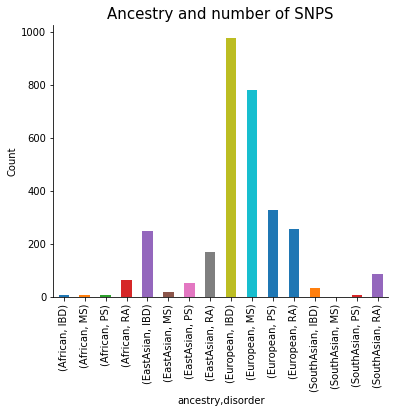

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

master_v2 = master_v1.drop_duplicates()

# disorders = ['MS','IBD','RA','PS']
# for disorder in disorders:
#     master_v2
#master_v2[master_v2['disorder']=='PS']
anc_count = master_v2.groupby(['ancestry','disorder'])['name_snp'].count()
ax = anc_count.plot(kind='bar', figsize=(6, 5), fontsize=10)
ax.set_alpha(0.8)
ax.set_title("Ancestry and number of SNPS", fontsize=15)
ax.set_ylabel("Count", fontsize=10)
sns.despine()
plt.show()

### Identify the number of SNPS in 300bp window

In [39]:
!head /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_point_snp_gene_atac.txt

	chr	start	end	chr_atac	start_atac	end_atac	name_atac	chr_snp	start_snp	end_snp	name_snp	ancestry	disorder	allele_string	minor_allele	origin	chr_gene	start_gene	end_gene	name_gene	gene_symbol	gene_type
0	chr1	1307506	1308516	chr1	1307506	1309208	chr1.1307507.1309208	chr1	1308516	1308516	rs61766198	European	IBD	C/G/T	T	ld	chr1	1292388.0	1309609.0	ENSG00000131584.19	ACAP3	protein_coding
1	chr1	1307506	1308516	chr1	1307506	1309208	chr1.1307507.1309208	chr1	1308516	1308516	rs61766198	European	IBD	C/G/T	T	ld	chr1	1308595.0	1311677.0	ENSG00000169972.12	PUSL1	protein_coding
2	chr1	2545951	2547072	chr1	2545951	2549272	chr1.2545952.2549272	chr1	2547072	2547072	rs2477678	EastAsian	IBD	T/A/G	T	ld	chr1	2530062.0	2547460.0	ENSG00000272449.2	AL139246.5	lncRNA
3	chr1	2545951	2547072	chr1	2545951	2549272	chr1.2545952.2549272	chr1	2547072	2547072	rs2477678	European	IBD	T/A/G	T	ld	chr1	2530062.0	2547460.0	ENSG00000272449.2	AL139246.5	lncRNA
4	chr1	2545951	2548544	chr1	2545951	2549272	chr1.2545952.254927

In [3]:
import pandas as pd

masterTable = pd.read_csv('/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.txt', sep='\t')

snp_coordinates = masterTable[['chr_snp','start_snp','end_snp','name_snp']]

snp_coordinates.drop_duplicates().to_csv('/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.bed', sep='\t', header=None, index=False)


In [4]:
!wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.bed

2330 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.bed


In [5]:
%%bash
cat /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.bed \
| awk -vOFS="\t" '{print $1,$2,$3,$1"_"$2"_"$3}' \
| sort -k1,1 -k2,2n \
> /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.sorted.bed

In [6]:
!head /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.sorted.bed

chr1	1308516	1308516	chr1_1308516_1308516
chr1	2547072	2547072	chr1_2547072_2547072
chr1	2548544	2548544	chr1_2548544_2548544
chr1	2556224	2556224	chr1_2556224_2556224
chr1	2556327	2556327	chr1_2556327_2556327
chr1	2556714	2556714	chr1_2556714_2556714
chr1	2557169	2557169	chr1_2557169_2557169
chr1	2585342	2585342	chr1_2585342_2585342
chr1	2642639	2642639	chr1_2642639_2642639
chr1	2652813	2652813	chr1_2652813_2652813


In [7]:
%%bash
bedtools closest \
  -io \
  -D a \
  -a /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.sorted.bed \
  -b /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.sorted.bed \
> /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.with_distance.sorted.bed



In [8]:
%%bash
sbatch -p all \
    --mem 64G \
    <<'EOF'
#!/bin/bash
bedtools makewindows \
-g /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.sorted.bed \
-w 300 \
> /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.with_window.sorted.bed

EOF

Submitted batch job 28131872


In [9]:
!head /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.with_distance.sorted.bed

chr1	1308516	1308516	chr1_1308516_1308516	chr1	2547072	2547072	chr1_2547072_2547072	1238555
chr1	2547072	2547072	chr1_2547072_2547072	chr1	2548544	2548544	chr1_2548544_2548544	1471
chr1	2548544	2548544	chr1_2548544_2548544	chr1	2547072	2547072	chr1_2547072_2547072	-1471
chr1	2556224	2556224	chr1_2556224_2556224	chr1	2556327	2556327	chr1_2556327_2556327	102
chr1	2556327	2556327	chr1_2556327_2556327	chr1	2556224	2556224	chr1_2556224_2556224	-102
chr1	2556714	2556714	chr1_2556714_2556714	chr1	2556327	2556327	chr1_2556327_2556327	-386
chr1	2557169	2557169	chr1_2557169_2557169	chr1	2556714	2556714	chr1_2556714_2556714	-454
chr1	2585342	2585342	chr1_2585342_2585342	chr1	2557169	2557169	chr1_2557169_2557169	-28172
chr1	2642639	2642639	chr1_2642639_2642639	chr1	2652813	2652813	chr1_2652813_2652813	10173
chr1	2652813	2652813	chr1_2652813_2652813	chr1	2653605	2653605	chr1_2653605_2653605	791


In [10]:
import pandas as pd
import numpy as np

snp_with_distance = pd.read_csv('/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_all_snp_gene_atac.with_distance.sorted.bed', sep='\t', 
                               names=['chr_1','start_1','end_1','chr_start_end_1','chr_2','start_2','end_2','chr_start_end_2','distance'])
#snp_with_distance = snp_with_distance[['chr_start_end_1','chr_start_end_2','distance']]
#snp_with_distance

snp_with_coordinates = snp_with_distance[['chr_1','start_1','end_1','chr_start_end_1']]
snp_with_coordinates = snp_with_coordinates.drop_duplicates(subset=['chr_start_end_1'])

levels = list(set(snp_with_distance['chr_1']))
start_index={}
for level in levels:
    start = snp_with_distance.loc[snp_with_distance['chr_1']==level, 'start_1'].iloc[0]
    start_index[level] = start
    
    
start_index_df = pd.DataFrame(list(start_index.items()),columns=['chr_1', 'start_index'])

snp_with_coordinates_start_index = snp_with_coordinates.merge(start_index_df, on='chr_1', how='outer')
snp_with_coordinates_start_index['diff'] = snp_with_coordinates_start_index['start_1'] - snp_with_coordinates_start_index['start_index']
# snp_with_coordinates_start_index.head()
snp_with_coordinates_start_index['diff'] = snp_with_coordinates_start_index['diff']//300

snp_with_coordinates_start_index['start'] = snp_with_coordinates_start_index['start_index'] + (snp_with_coordinates_start_index['diff']*300)
snp_with_coordinates_start_index['keystr'] = snp_with_coordinates_start_index['chr_1'].astype('str') + '_' + snp_with_coordinates_start_index['start'].astype('str')+'_'+(snp_with_coordinates_start_index['start']+300).astype('str')
snp_windows = snp_with_coordinates_start_index.groupby(['keystr']).size().reset_index(name='count')

snp_window_count = snp_with_coordinates_start_index.merge(snp_windows, on='keystr',how='outer')

snp_window_count.sort_values(by='count', ascending=False)
# a = snp_window_count[['keystr','count']].drop_duplicates().sort_values(by='count', ascending=False)
# a[a['count']==2]

,chr_1,start_1,end_1,chr_start_end_1,start_index,diff,start,keystr,count
1850,chr6,32609678,32609678,chr6_32609678_32609678,528568,106937,32609668,chr6_32609668_32609968,15
1864,chr6,32609956,32609956,chr6_32609956_32609956,528568,106937,32609668,chr6_32609668_32609968,15
1852,chr6,32609695,32609695,chr6_32609695_32609695,528568,106937,32609668,chr6_32609668_32609968,15
1853,chr6,32609697,32609697,chr6_32609697_32609697,528568,106937,32609668,chr6_32609668_32609968,15
1854,chr6,32609754,32609754,chr6_32609754_32609754,528568,106937,32609668,chr6_32609668_32609968,15
1855,chr6,32609772,32609772,chr6_32609772_32609772,528568,106937,32609668,chr6_32609668_32609968,15
1856,chr6,32609786,32609786,chr6_32609786_32609786,528568,106937,32609668,chr6_32609668_32609968,15
1857,chr6,32609809,32609809,chr6_32609809_32609809,528568,106937,32609668,chr6_32609668_32609968,15
1858,chr6,32609813,32609813,chr6_32609813_32609813,528568,106937,32609668,chr6_32609668_32609968,15
1859,chr6,32609856,32609856,chr6_32609856_32609856,528568,106937,32609668,chr6_32609668_32609968,15


In [4]:
!wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_snp_coordinates.bed

2362 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_snp_coordinates.bed


In [1]:
!head /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/MasterTable_snp_coordinates.bed

chr1	1308516	1308517	rs61766198
chr1	2547072	2547073	rs2477678
chr1	2548544	2548545	rs1974044
chr1	2556224	2556225	rs2227312
chr1	2556327	2556328	rs2227313
chr1	2556714	2556715	rs4870
chr1	2557169	2557170	rs1886730
chr1	2585342	2585343	rs60733400
chr1	2642639	2642640	rs9970196
chr1	2652813	2652814	rs4648665
